In [1]:
# Impoting the Libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Importing the File
uber = pd.read_csv("Uber Request Data.csv")
uber.head()

Request id Pickup point  Driver id          Status    Request timestamp  \
0         619      Airport        1.0  Trip Completed      11/7/2016 11:51   
1         867      Airport        1.0  Trip Completed      11/7/2016 17:57   
2        1807         City        1.0  Trip Completed       12/7/2016 9:17   
3        2532      Airport        1.0  Trip Completed      12/7/2016 21:08   
4        3112         City        1.0  Trip Completed  13-07-2016 08:33:16   

        Drop timestamp  
0      11/7/2016 13:00  
1      11/7/2016 18:47  
2       12/7/2016 9:58  
3      12/7/2016 22:03  
4  13-07-2016 09:25:47

In [3]:
# Checking for the Data Type of each column
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB


In [4]:
# Changing the Data Type as convenient
uber['Request timestamp'] = uber['Request timestamp'].astype(str)
uber['Request timestamp'] = uber['Request timestamp'].str.replace('/','-')
uber['Request timestamp'] = pd.to_datetime(uber['Request timestamp'],dayfirst=True)

uber['Drop timestamp'] = uber['Drop timestamp'].astype(str)
uber['Drop timestamp'] = uber['Drop timestamp'].str.replace('/','-')
uber['Drop timestamp'] = pd.to_datetime(uber['Drop timestamp'],dayfirst=True)

In [5]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null datetime64[ns]
Drop timestamp       2831 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 316.2+ KB


In [6]:
# Checking of Null values in DataFrame and their percentages
print(uber.isnull().sum())
round(uber.isnull().sum()/(len(uber.index))*100,2)

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64


Request id            0.00
Pickup point          0.00
Driver id            39.29
Status                0.00
Request timestamp     0.00
Drop timestamp       58.03
dtype: float64

There are some null values in Driver id and Drop timestamp it is because of the cancellation

In [7]:
uber.shape

(6745, 6)

In [8]:
# Checking for number of duplicated row.
sum(uber.duplicated(subset='Request id')) == 0

True

Since it is zero hence there are no Duplicate rows.

In [9]:
# Since the data metric which need to be derived here is hour we need to extract it from the both timestamps
# Extracting
uber_hour_re = uber["Request timestamp"].dt.hour
uber["uber_hour_re"] = uber_hour_re

# Differentiating the Supply-Demand Gap by adding a new column Service
uber["Service"] = uber["Status"].apply(lambda x: "Serviced" if x=="Trip Completed" else "Denied")

uber.head()

Request id Pickup point  Driver id          Status   Request timestamp  \
0         619      Airport        1.0  Trip Completed 2016-07-11 11:51:00   
1         867      Airport        1.0  Trip Completed 2016-07-11 17:57:00   
2        1807         City        1.0  Trip Completed 2016-07-12 09:17:00   
3        2532      Airport        1.0  Trip Completed 2016-07-12 21:08:00   
4        3112         City        1.0  Trip Completed 2016-07-13 08:33:16   

       Drop timestamp  uber_hour_re   Service  
0 2016-07-11 13:00:00            11  Serviced  
1 2016-07-11 18:47:00            17  Serviced  
2 2016-07-12 09:58:00             9  Serviced  
3 2016-07-12 22:03:00            21  Serviced  
4 2016-07-13 09:25:47             8  Serviced

In [10]:
# Creating different slots based on request hour 
def divide_hour(x):
    if x<5:
        return "Pre Morning"
    elif 5 <= x <= 9:
        return "Morning Rush"
    elif 10 <= x <= 16:
        return "Day_Time"
    elif 17 <= x <= 21:
        return "Evening_Rush"
    else:
        return "Late_Night"
    
uber["Slot_name"] = uber.uber_hour_re.apply(lambda x: divide_hour(x))
uber.head()

Request id Pickup point  Driver id          Status   Request timestamp  \
0         619      Airport        1.0  Trip Completed 2016-07-11 11:51:00   
1         867      Airport        1.0  Trip Completed 2016-07-11 17:57:00   
2        1807         City        1.0  Trip Completed 2016-07-12 09:17:00   
3        2532      Airport        1.0  Trip Completed 2016-07-12 21:08:00   
4        3112         City        1.0  Trip Completed 2016-07-13 08:33:16   

       Drop timestamp  uber_hour_re   Service     Slot_name  
0 2016-07-11 13:00:00            11  Serviced      Day_Time  
1 2016-07-11 18:47:00            17  Serviced  Evening_Rush  
2 2016-07-12 09:58:00             9  Serviced  Morning Rush  
3 2016-07-12 22:03:00            21  Serviced  Evening_Rush  
4 2016-07-13 09:25:47             8  Serviced  Morning Rush

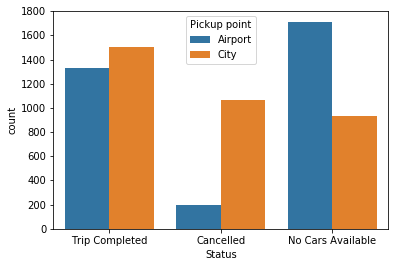

In [11]:
# Frequency of requests that get cancelled or show no cars available
# At both the pickup points
sns.countplot(x = "Status", hue = "Pickup point", data = uber)

As we can see from the above plot at the pick up point city most of trips are cancelled and at the pick up point airport most of the trip are not taken because of no cars available due to the lack of organic flow.

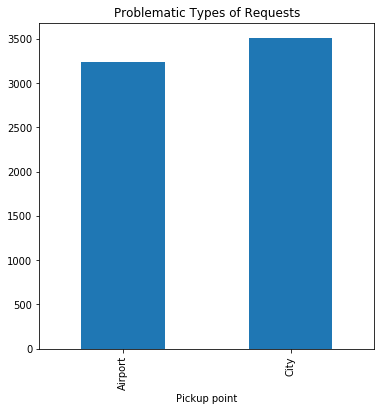

In [12]:
# Problematic Types of Requests (City to Airport / Airport to City)
uber.groupby(['Pickup point']).size().plot(kind="bar",figsize=(6, 6),title="Problematic Types of Requests")
plt.show()

As we can see from the above plot most problematic type of requests are from the pickup point city as compared to that of the airport.

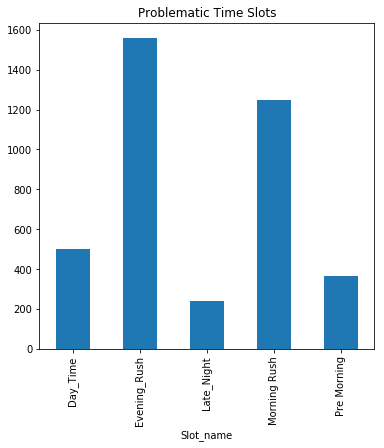

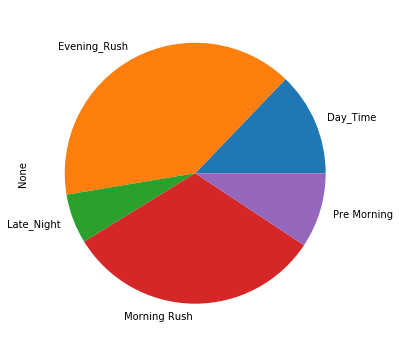

In [13]:
# Most Problematic time slots 
uber[(uber.Service=="Denied")].groupby(['Slot_name']).size().plot(kind="bar",stacked=True,figsize=(6, 6),title="Problematic Time Slots")
plt.show()
uber[(uber.Service=="Denied")].groupby(['Slot_name']).size().plot(kind="pie",stacked=True,figsize=(6, 6),)
plt.show()

As we can see from the above plots Morning Rush and Evening Rush are the two time slots which are more problematic compared to the other slots.

Text(0.5, 1.0, 'Number of Requests by Request Hour')

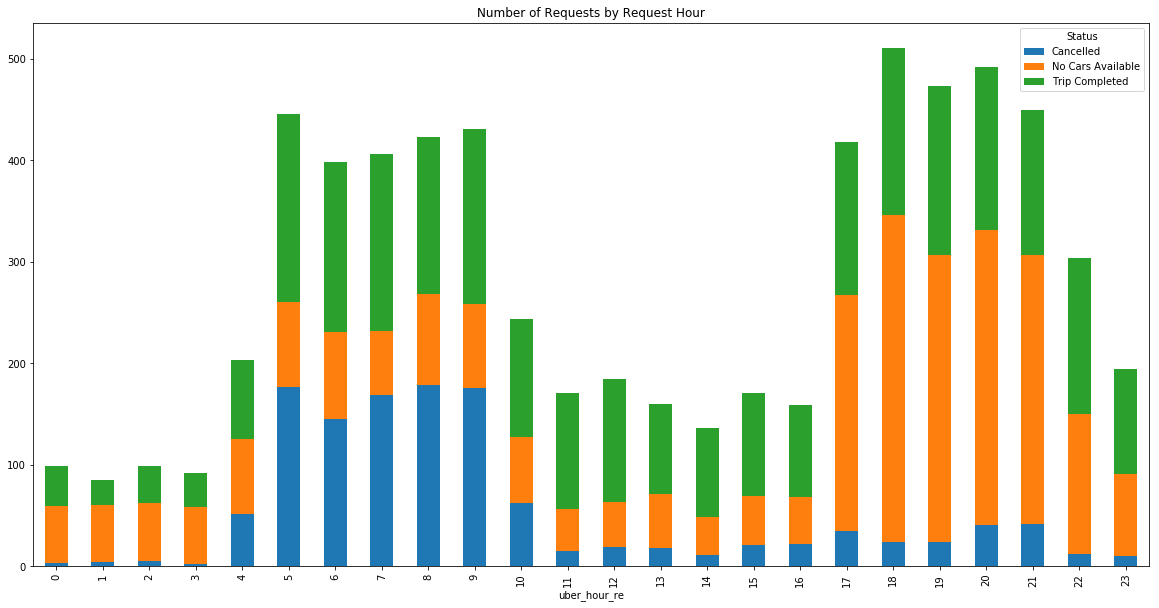

In [14]:
# Number of Requests
uber.groupby(['uber_hour_re','Status']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10))
plt.title('Number of Requests by Request Hour')

As we can see from the above plot many requests have been cancelled during the hours between 5 and 9 (Morning Rush) and during the request hours 17 to 21 (Evening Rush) there is a concern of no cars available due to the lack of organic flow.

Text(0.5, 1.0, 'Time slots where highest Gap exists')

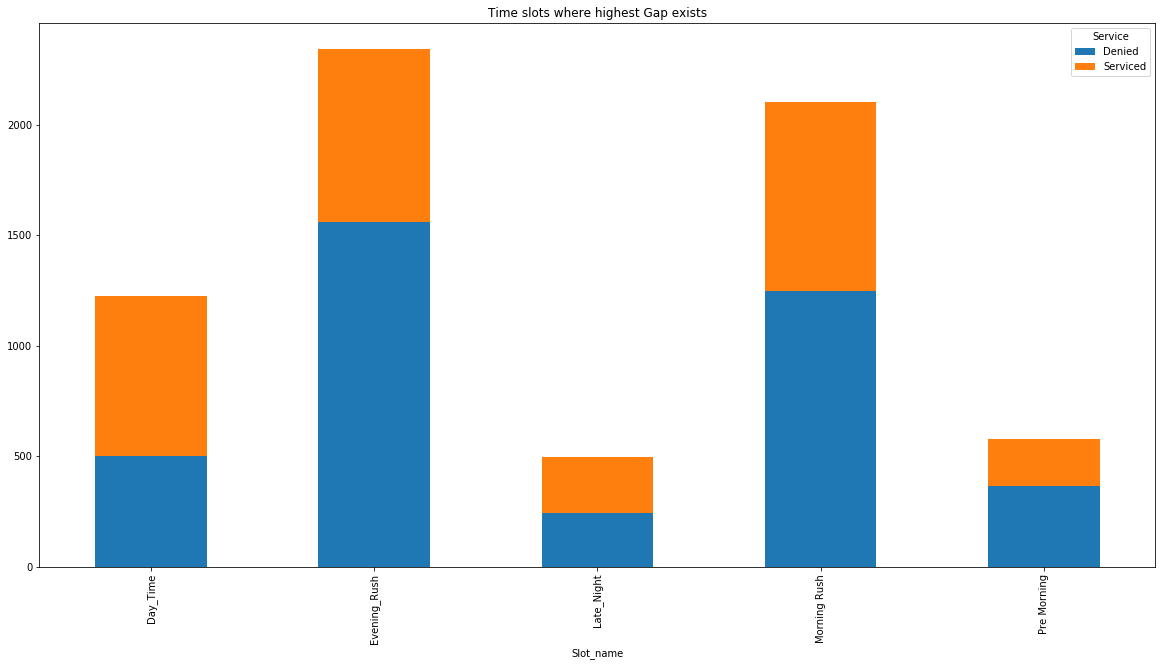

In [15]:
# Time slots where highest Gap exists
uber.groupby(['Slot_name','Service']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10))
plt.title('Time slots where highest Gap exists')

From the above plot it is clear that Moring Rush and the Evening Rush are the two slots for which the highest time gap exists.

Text(0.5, 1.0, 'Demand-Supply Gap from City to Airport')

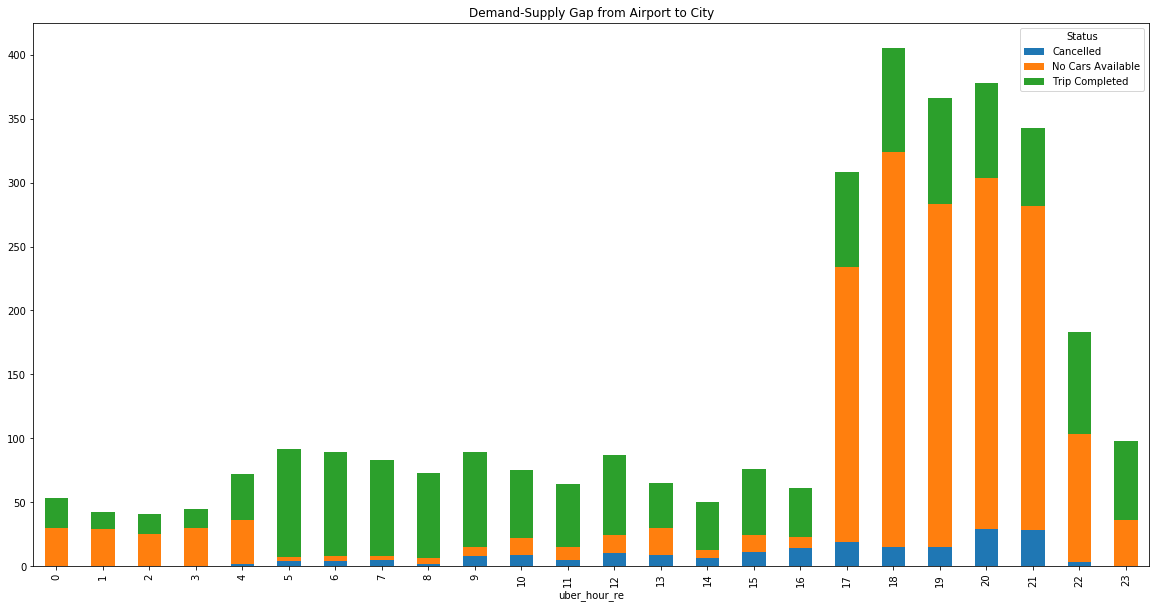

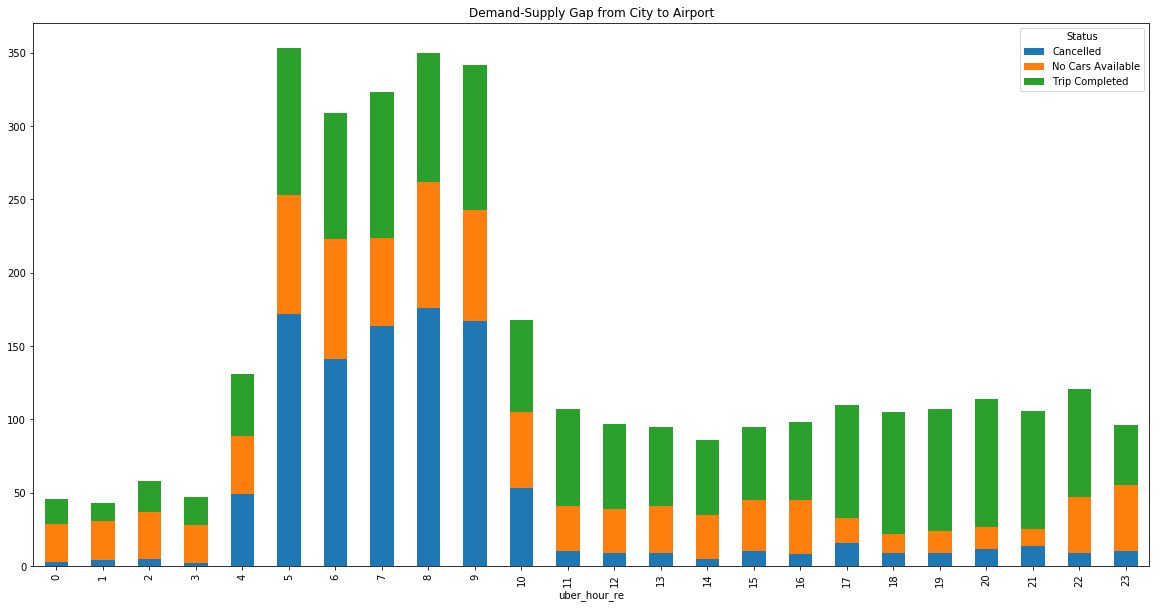

In [16]:
# Types of Requests (City-Airport or Airport-City) for which the Demand Supply Gap is the most severe
# in the identified Time Slots

# Gap from Airport to City
uber[(uber['Pickup point']=="Airport")].groupby(['uber_hour_re','Status']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10))
plt.title('Demand-Supply Gap from Airport to City')

# Gap from City to Airport
uber[(uber['Pickup point']=="City")].groupby(['uber_hour_re','Status']).size().unstack().plot(kind='bar', stacked=True,figsize=(20, 10))


plt.title('Demand-Supply Gap from City to Airport')

# Reasons for such Demand-Supply Gap

From the above plots it is clear that in case of pickup point - City the Demand-Supply gap is high in the Time Slot Morning Rush (5AM to 9AM) because of more and more trips getting cancelled by the driver due to high waiting time after the trip at the airport and in case of pickup point - Airport the Demand-Supply gap is high in the Time Slot Evening Rush (5PM to 9PM) because of no cars available due to the lack of organic flow at the airport.

# Recommendations 
1. To resolve the problem of cancellations by the drivers during the morning rush we can firstly we can make the charges for this trip higher and inform the customers about the same in advance there by maintaining the transparency and then with the help of the amount difference which was increased we can thereby increase the pay off to the buyer and could encourage him to take up the trips.

2. To resolve the problem of no cars available during the evening rush at the airport we can apply the above solution and other way could be by introducing the concept of sharing a cab which would help in lesser cars serving greater amount of people

In [ ]:
;